In [7]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'ezephys'

In [2]:
obs_df = pd.read_csv('../../interneuron-reward-data/processed/mean_fluo_df.csv')

bootstrap_dfs = {
    ct: pd.read_csv(f'../../interneuron-reward-data/processed/{ct}_corr_bootstrap.csv')
    for ct in ('pyr', 'vip', 'pv')
}

In [3]:
def get_change(obs_df, cell_type: str) -> pd.DataFrame:
    d1 = obs_df.query('(day == 1) and (cell_type == @cell_type)').set_index('cell_id')
    d7 = obs_df.query('(day == 7) and (cell_type == @cell_type)').set_index('cell_id')
    if not np.all(d1.index.to_numpy() == d7.index.to_numpy()):
        warnings.warn('Index not completely matching.')
    change = d1.copy()
    change['reward'] = d7['reward'] - d1['reward']
    change['tone + delay'] = d7['tone + delay'] - d1['tone + delay']
    return change

In [4]:
def vertical_rects(x, y_min, y_max, width=0.5, **pltargs):
    label = pltargs.pop('label', None)
    for i, (x_i, ymin_i, ymax_i) in enumerate(zip(x, y_min, y_max)):
        fill = plt.fill_between(
            [x_i - width/2., x_i + width/2.], [ymin_i, ymin_i], [ymax_i, ymax_i], 
            **pltargs
        )
        if (i == 0) and (label is not None):
            fill.set_label(label)

In [23]:
stat_thresholds = {
    0.05: '*',
    0.01: '**',
}

<ipython-input-3-5eebf9752fee>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not np.all(d1.index.to_numpy() == d7.index.to_numpy()):
<ipython-input-3-5eebf9752fee>:5: UserWarning: Index not completely matching.
  warnings.warn('Index not completely matching.')


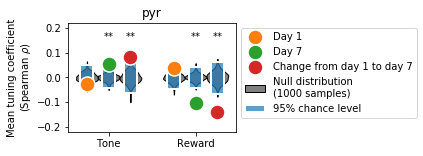

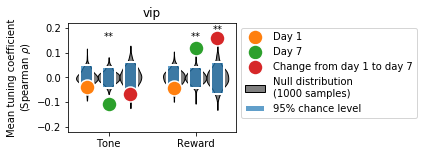

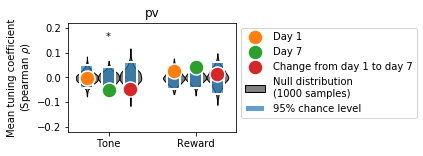

In [29]:
for ct, bs_df in bootstrap_dfs.items():
    # Null distributions
    null_arr = np.array([
        bs_df.query('(trial_component == "tone + delay") and (day == "1")')['spearman'],
        bs_df.query('(trial_component == "tone + delay") and (day == "7")')['spearman'],
        bs_df.query('(trial_component == "tone + delay") and (day == "delta")')['spearman'],
        bs_df.query('(trial_component == "reward") and (day == "1")')['spearman'],
        bs_df.query('(trial_component == "reward") and (day == "7")')['spearman'],
        bs_df.query('(trial_component == "reward") and (day == "delta")')['spearman']
    ]).T
    x_positions = [-0.5, 0, 0.5, 1.5, 2, 2.5]

    plt.figure(figsize=(3, 2))
    plt.subplot(111)
    plt.title(ct)
    violins = plt.violinplot(null_arr, x_positions, showextrema=False)

    for i, violin in enumerate(violins['bodies']):
        violin.set_edgecolor('k')
        violin.set_facecolor('gray')
        violin.set_alpha(1)
        if i == 0:
            violin.set_label('Null distribution\n(1000 samples)')

    # Plot 95% CI on null distributions
    vertical_rects(
        x_positions, np.percentile(data_arr, 2.5, axis=0), np.percentile(data_arr, 97.5, axis=0),
        width=0.3, facecolor=(*sns.color_palette()[0], 0.7), edgecolor=(1, 1, 1, 1), lw=2,
        label='95% chance level'
    )

    # Plot observed values
    change = get_change(obs_df, ct)
    y_obs = [
        obs_df.query('(day == 1) and (cell_type == @ct)').groupby('mouse_id').mean()['tone + delay'].mean(),
        obs_df.query('(day == 7) and (cell_type == @ct)').groupby('mouse_id').mean()['tone + delay'].mean(),
        change.groupby('mouse_id').mean()['tone + delay'].mean(),
        obs_df.query('(day == 1) and (cell_type == @ct)').groupby('mouse_id').mean()['reward'].mean(),
        obs_df.query('(day == 7) and (cell_type == @ct)').groupby('mouse_id').mean()['reward'].mean(),
        change.groupby('mouse_id').mean()['reward'].mean(),
    ]
    labels = ['Day 1', 'Day 7', 'Change from day 1 to day 7']
    for i, (x_pos, y) in enumerate(zip(x_positions, y_obs)):
        pt = plt.plot(x_pos, y, 'o', color=sns.color_palette()[i%3+1], markersize=15, markeredgecolor='w', mew=1.5)
        if i < 3:
            pt[0].set_label(labels[i])

    # Add statistical annotations
    for i, x_pos in enumerate(x_positions):
        for stat_thresh in [0.01, 0.05]:
            if (y_obs[i] < np.percentile(null_arr[:, i], 100 * stat_thresh/2.)
               ) or (y_obs[i] > np.percentile(null_arr[:, i], 100 * (1-stat_thresh/2.))):
                plt.annotate(
                    stat_thresholds[stat_thresh], 
                    (x_pos, max(0.15, y_obs[i] + 0.02)), 
                    ha='center'
                )
                break
    
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

    plt.xticks([0, 2], ['Tone', 'Reward'])
    plt.ylim(-0.22, 0.22)
    plt.ylabel('Mean tuning coefficient\n(Spearman $\\rho$)')
    
    plt.savefig(f'../img/bootstrap/{ct}_corr.png', dpi=600, bbox_inches='tight')
    plt.savefig(f'../img/bootstrap/{ct}_corr.svg', bbox_inches='tight')

In [15]:
np.percentile(null_arr[:, i], 100 * stat_thresh/2.)

-0.037354430538614

In [7]:
get_change(obs_df, ct)

<ipython-input-4-b155d89a5ff6>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert np.all(d1['cell_id'].to_numpy() == d7['cell_id'].to_numpy())


AssertionError: 

In [8]:
ct

'vip'

In [30]:
d1 = obs_df.query('(day == 1) and (cell_type == "vip")').sort_values('cell_id')
d7 = obs_df.query('(day == 7) and (cell_type == "vip")').sort_values('cell_id')

In [31]:
len(d7['cell_id'])

406

In [32]:
d1.set_index('cell_id', inplace=True)
d7.set_index('cell_id', inplace=True)
np.isnan(d7['reward'] - d1['reward']).sum()

1

In [16]:
d1['reward']

240   -0.115722
242    0.291399
244   -0.058858
246    0.354561
248    0.050883
         ...   
673   -0.119824
675   -0.171661
677    0.222572
679   -0.282788
681    0.140166
Name: reward, Length: 407, dtype: float64

In [17]:
d7['reward']

241    0.432980
243    0.008119
245    0.112428
247   -0.028345
249    0.100061
         ...   
674    0.395822
676    0.196336
678    0.276547
680    0.269497
682   -0.024994
Name: reward, Length: 406, dtype: float64

In [23]:
d1.set_index('cell_id', inplace=True)

In [24]:
d1

,day,cell_type,mouse_id,tone,tone + delay,reward
cell_id,,,,,,
2894,1,vip,CL144,-0.213334,-0.348494,-0.115722
2895,1,vip,CL144,-0.069744,-0.127568,0.291399
2896,1,vip,CL144,-0.119402,-0.164148,-0.058858
2897,1,vip,CL144,-0.174616,-0.410905,0.354561
2898,1,vip,CL144,0.025812,-0.072611,0.050883
...,...,...,...,...,...,...
3522,1,vip,CL146,-0.309403,-0.202289,-0.119824
3523,1,vip,CL146,-0.057094,-0.093184,-0.171661
3524,1,vip,CL146,-0.093334,-0.217256,0.222572
